# Tema 5: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 clase din setul [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara.
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. In definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

1. Optional:
    1. Folositi alt optimizator decat SGD, de ex. Adam. Comparati cu rezultatele obtinute pe SGD.
    1. Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se va face pana in săptămâna **27 noiembrie - 2 decembrie**, in cadrul assignementului temei 5 de pe platforma. Modul de predare si de prezentare este la fel ca pentru temele precedente.


Importarea pachetelor


In [39]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from typing import Tuple
import matplotlib.pyplot as plt
from torchsummary import summary

Definim Dataset

In [40]:
class FashionMNISTDataset(Dataset):
    def __init__(self, path_csv):
        # Explicitly specify data types and skip the header row
        _all_items = pd.read_csv(path_csv, header=None, skiprows=1, dtype='float32').values

        _y = _all_items[:, 0]
        _x = _all_items[:, 1:]
        _x = _x / 255.0  # Convert to float before division

        self.x = torch.Tensor(_x)
        self.y = torch.Tensor(_y).long()  # Assuming labels are integers

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [41]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, num_classes: int = 10):
        super(MultinomialLogisticRegression, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.fully_connected = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fully_connected(x)
        return x

In [42]:
# Creare seturi de date și încărcare în DataLoader
train_ds = FashionMNISTDataset('/content/drive/MyDrive/Uni/IA/lab8/data/fashion-mnist_test.csv')
test_ds = FashionMNISTDataset('/content/drive/MyDrive/Uni/IA/lab8/data/fashion-mnist_train.csv')
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)


In [43]:
model = MultinomialLogisticRegression(input_size=784, num_classes=10)
summary(model, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [44]:
print(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


In [45]:
print(f'device={device}')
model.to(device)

device=cuda


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [122]:
def test_multinomial(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Testează modelul pe datele furnizate de :param loader:
    :param model: model de regresie logistica multinomiala
    :param loader: un dataloader care furnizează datele din setul de testare
    :param device: pe ce device se află modelul (cpu, gpu, tpu etc)
    :return: acuratețea de predicție
    """
    # initializare valori pentru statistica
    correctly_classified = 0
    total_items = 0

    # când se face testarea, modelul nu mai învață. El e trecut explicit în modul de testare
    model.eval()

    # dezactivăm urmărirea automată a tensorilor pentru care nu se calculează gradienti:
    # gradientii sunt folosiți doar la antrenare, nu și la testare
    with torch.no_grad():
        for x, y in loader:
            # trecem datele din setul de testare pe același device ca și modelul
            x, y = x.to(device), y.to(device)

            # modelul prezice logitii (valoarea produsă de aplicarea stratului liniar, fără softmax)
            logits = model(x)

            # determinăm clasa prezisă ca fiind cea cu scorul maxim (fără softmax)
            _, predicted_classes = torch.max(logits, 1)

            correctly_classified += torch.eq(predicted_classes, y).sum().item()
            total_items += len(x)

    accuracy = correctly_classified / total_items
    return accuracy

In [123]:
for x, y in train_loader:
    # datele și modelul trebuie să fie pe același device, altfel calculele nu se pot efectua
    x, y = x.to(device), y.to(device)

    # produce predictia, tensor plin cu probabilitati
    y_hat = model(x).squeeze()
    print(f'Predictii (probabilitati): {y_hat}')

    # indicele clasei prezise pentru fiecare element din minibatch
    _, clase = torch.max(y_hat, 1)

    # folosim torch.eq pentru a face o comparatie element-cu-element
    correctly_predicted = torch.sum(torch.eq(clase, y))
    print('Cate clase au fost prezise corect: ', correctly_predicted)

    # ne oprim dupa primul minibatch aici, e doar pentru a vedea cum arata predictiile facute de model
    break

Predictii (probabilitati): tensor([[ 5.5402e-01,  1.5695e+00,  9.8477e+00, -3.0905e+00,  1.2406e+01,
         -7.8348e+00,  4.6257e+00, -1.1896e+01,  1.4725e+00, -7.6551e+00],
        [-2.3453e+00, -3.1221e+00,  2.6231e+00, -3.4572e+00, -3.3486e-01,
          1.6241e+00,  2.7161e+00, -4.9498e+00,  1.2129e+01, -4.8833e+00],
        [ 2.7093e+00,  8.8748e+00,  1.6291e-01,  3.6332e+00,  3.4214e+00,
         -7.5072e+00, -2.0601e+00, -2.4596e+00, -9.6601e-01, -5.8091e+00],
        [ 6.3487e-02,  6.8599e-01,  8.5660e+00,  2.4990e-02,  7.2685e+00,
         -6.2831e+00,  3.6763e+00, -6.0896e+00, -5.9799e-01, -7.3153e+00],
        [-5.0798e+00, -3.8323e+00, -1.4327e+00, -2.4053e+00, -3.4159e+00,
          5.4972e+00, -3.6534e+00,  1.0254e+01,  1.2919e+00,  2.7760e+00],
        [ 2.4183e+00,  1.8715e+00,  5.3611e+00,  6.0143e+00,  3.2491e+00,
         -7.2495e+00,  5.0852e+00, -8.2420e+00, -7.5672e-01, -7.7522e+00],
        [-4.8176e+00, -6.8016e+00, -4.0287e+00, -4.6977e+00, -3.2900e+00,
     

In [124]:
acc = test_multinomial(model, test_loader, device)
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

Acuratetea modelului neantrenat: 82.40666666666667%


In [150]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [144]:
epochs = 30

In [151]:
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    total_items = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_hat = model(x)

        loss = loss_fn(y_hat, y)
        epoch_loss += loss.item() * len(x)
        total_items += len(x)

        loss.backward()
        optimizer.step()

    epoch_loss /= total_items
    losses.append(epoch_loss)

    # Evaluare model pe setul de testare
    acc_test = test_multinomial(model, test_loader, device)
    accuracies.append(acc_test)

    print(f'Epoca: {epoch+1}/{epochs}, Loss: {epoch_loss:.7f}, Acuratete pe test: {acc_test * 100:.4f}%')

Epoca: 1/30, Loss: 0.3541245, Acuratete pe test: 84.4750%
Epoca: 2/30, Loss: 0.3512315, Acuratete pe test: 84.5083%
Epoca: 3/30, Loss: 0.3506489, Acuratete pe test: 84.5250%
Epoca: 4/30, Loss: 0.3503047, Acuratete pe test: 84.5467%
Epoca: 5/30, Loss: 0.3503025, Acuratete pe test: 84.5383%
Epoca: 6/30, Loss: 0.3502060, Acuratete pe test: 84.5467%
Epoca: 7/30, Loss: 0.3500666, Acuratete pe test: 84.5533%
Epoca: 8/30, Loss: 0.3500501, Acuratete pe test: 84.5617%
Epoca: 9/30, Loss: 0.3500122, Acuratete pe test: 84.5717%
Epoca: 10/30, Loss: 0.3499478, Acuratete pe test: 84.5467%
Epoca: 11/30, Loss: 0.3499217, Acuratete pe test: 84.5750%
Epoca: 12/30, Loss: 0.3498584, Acuratete pe test: 84.5467%
Epoca: 13/30, Loss: 0.3495993, Acuratete pe test: 84.5700%
Epoca: 14/30, Loss: 0.3497639, Acuratete pe test: 84.5450%
Epoca: 15/30, Loss: 0.3498022, Acuratete pe test: 84.5817%
Epoca: 16/30, Loss: 0.3498081, Acuratete pe test: 84.5800%
Epoca: 17/30, Loss: 0.3497247, Acuratete pe test: 84.5683%
Epoca:

In [152]:
acc = test_multinomial(model, test_loader, device)
print(f'Acuratetea modelului antrenat: {acc * 100}%')

Acuratetea modelului antrenat: 84.55333333333334%


In [153]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

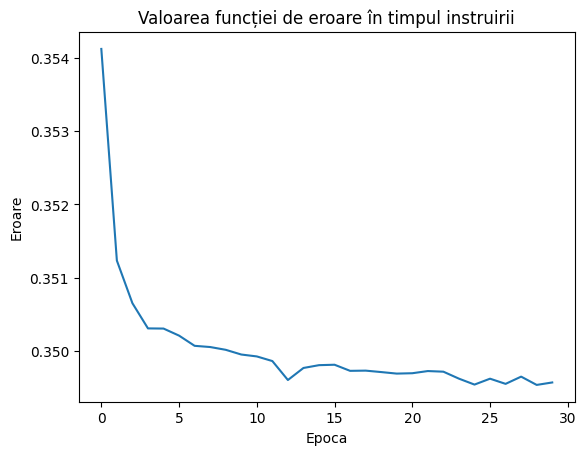

In [154]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Eroare')
plt.title(f'Valoarea funcției de eroare în timpul instruirii')
plt.show()

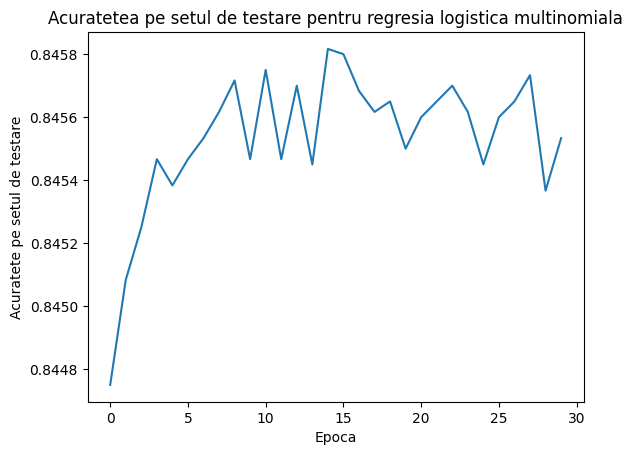

In [155]:
plt.plot(accuracies)
plt.xlabel('Epoca')
plt.ylabel('Acuratete pe setul de testare')
plt.title(f'Acuratetea pe setul de testare pentru regresia logistica multinomiala')
plt.show()

Matricea de confuzie


In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [156]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def print_confusion_matrix(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, labels in loader:
            x, labels = x.to(device), labels.to(device)

            # Modelul prezice etichetele
            predictions = model(x)

            # Determinăm clasa prezisă ca fiind cea cu probabilitatea maximă
            _, predicted_classes = torch.max(predictions, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_classes.cpu().numpy())

    # Creare matrice de confuzie
    cm = confusion_matrix(y_true, y_pred)

    # Afișare matrice de confuzie
    print("Matrice de Confuzie:")
    print(cm)

# Exemplu de utilizare
print_confusion_matrix(model, test_loader, device)

Matrice de Confuzie:
[[4949    9  109  266   26    8  569    1   62    1]
 [  22 5723   29  166   27    0   29    0    4    0]
 [ 101   15 4416   57  809    5  559    1   37    0]
 [ 246   57   92 5148  200    1  230    1   24    1]
 [  18    7  594  181 4641    2  530    0   27    0]
 [   4    3    1    6    0 5492    4  297   50  143]
 [ 894   12  710  152  654    1 3492    1   83    1]
 [   0    0    0    0    0  216    0 5570   14  200]
 [  41    6   37   47   19   47  119   26 5652    6]
 [   1    1    1    2    0   97    3  243    3 5649]]
